In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.offline import plot
from IPython.display import IFrame
import shutil

from matplotlib.patches import Rectangle
import sklearn.preprocessing as pp

print (sys.version)

3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 21:52:21) 
[GCC 7.3.0]


In [ ]:
Samples = [
    "S0008","S0009","S0014","S0017","S0025",
    "S0026","S0030","S0042","S0057","S0085",
    "COV00075","COV00079","COV00084","COV00087","COV00093","COV00106",
    "COV00397","COV00413","COV00417","COV00419","COV00422","COV00432"    
]

In [ ]:
renameSamples = [S.replace('S', 'COV0') for S in Samples]

I'm loading the motif analysis result to subset windows with motifs which expect to have m6A modification. 

In [ ]:
motif_df = pd.read_csv('Results/window_motif_analysis.txt', sep='\t')
motif_df

Let's select regions with `DRACH` and `RGAC` motifs for below analysis:

In [ ]:
peaks_with_motifs = motif_df[
    (motif_df.DRACH > 1) 
    # & (motif_df.DRACH < 8) 
    &
    (motif_df.RGAC > 1)
#     &
#     (motif_df.AAGAA > 0)
].loci.tolist()
len(peaks_with_motifs)

To draw heatmap and add borders around significant results, I wrote these functions. I'll use them to show plots in this notebook. You can tell it `save` and then, include arbitrary name as `name_it` to save `png` and `pdf` file. 

In [2]:
def add_border(plot,sig):
    '''
    For a given heatmap plot [plot], this function draw rectangles 
    around an array defined as list in the input indices.  
    '''
    a,b = sig
    plot.add_patch(Rectangle((a, b), 1, 1, fill=False, edgecolor='red', lw=3))

def make_significant_list(p_val_binary):
    '''
    Make list from row and column of significant coordinates. The result can be used for
    option 'borders' in the `draw_heatmap` function.
    '''
    I, J = p_val_binary.shape
    sig_list = []
    for i in range(I):
        for j in range(J):
            if p_val_binary.iloc[i,j] == True:
                sig_list.append((j,i)) # i and j are reversed but it works!
    return sig_list
    
def draw_heatmap(data, cluster=False, borders=None, save=False, name_it='', figsize=(24,6), vmin=None,vmax=None):
    '''
    Draw/save heatmap plot with option to draw rectangle around given cells. 
    '''
    if cluster:
        c = sns.clustermap(
            data,col_cluster=False,linewidth=2,vmin=vmin,vmax=vmax,
            method = 'complete',figsize=figsize)
        bottom, top = c.ax_heatmap.get_ylim()
        c.ax_heatmap.set_ylim(bottom + 0.5, top - 0.5)

    else: 
        plt.figure(figsize=figsize)
        heat_map = sns.heatmap(data,linewidth=2, vmin=vmin,vmax=vmax)
        bottom, top = heat_map.get_ylim()
        heat_map.set_ylim(bottom + 0.5, top - 0.5)
        heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    # add borders 
    if borders: 
        for sig in borders: add_border (heat_map,sig)
    if save:
        plt.savefig(name_it + '.png')
        plt.savefig(name_it + '.pdf')
    else:
        plt.show()

Ok! Here I load `ctest` results 

In [187]:
P_VALUE = 5

log_p  = pd.read_csv('Results/ctest_Log_p_win.txt', sep='\t',index_col=0 ).loc[:,peaks_with_motifs]
log_fdr= pd.read_csv('Results/ctest_Log_fdr_win.txt', sep='\t',index_col=0).loc[:,peaks_with_motifs]
log_fc = pd.read_csv('Results/ctest_Log_fc_win.txt', sep='\t',index_col=0).loc[:,peaks_with_motifs]

p_val_binary = (-1)*log_p > P_VALUE

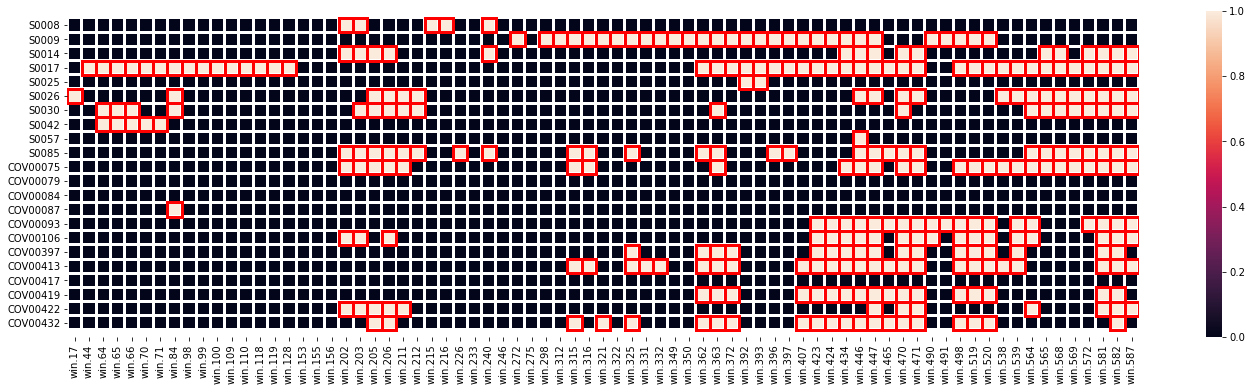

In [188]:
draw_heatmap(
    p_val_binary,
    borders=make_significant_list(p_val_binary)
)

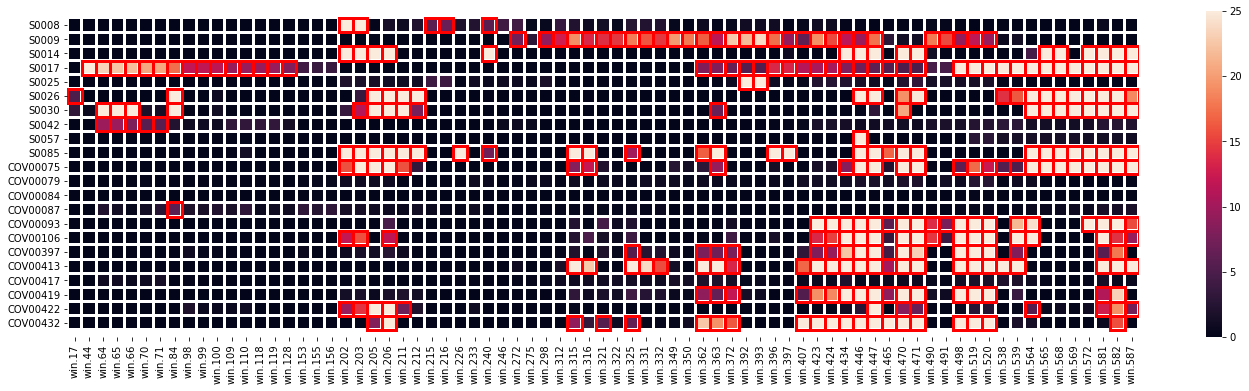

In [189]:
draw_heatmap(
    (-1)*log_p,
    borders=make_significant_list(p_val_binary), 
    vmax=25
)

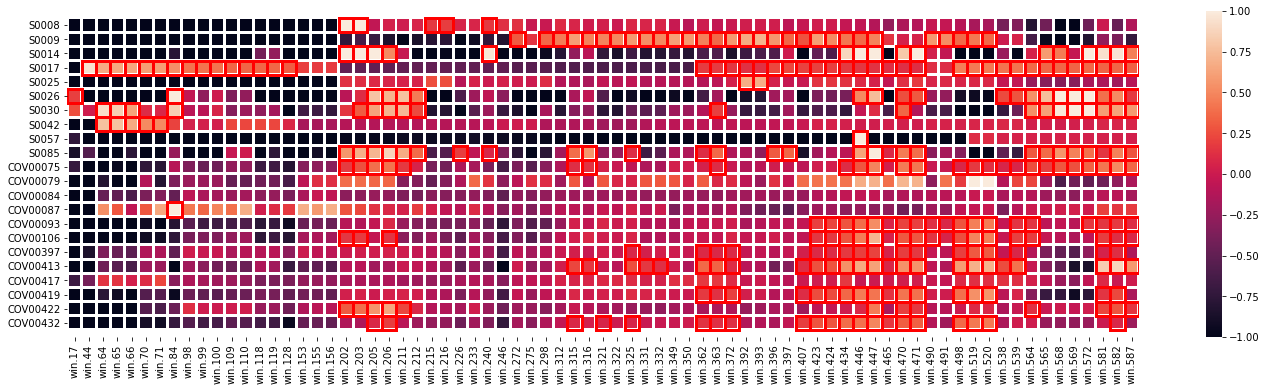

In [190]:
draw_heatmap(
    log_fc,
    borders=make_significant_list(p_val_binary),
    vmin=-1, vmax=1
)

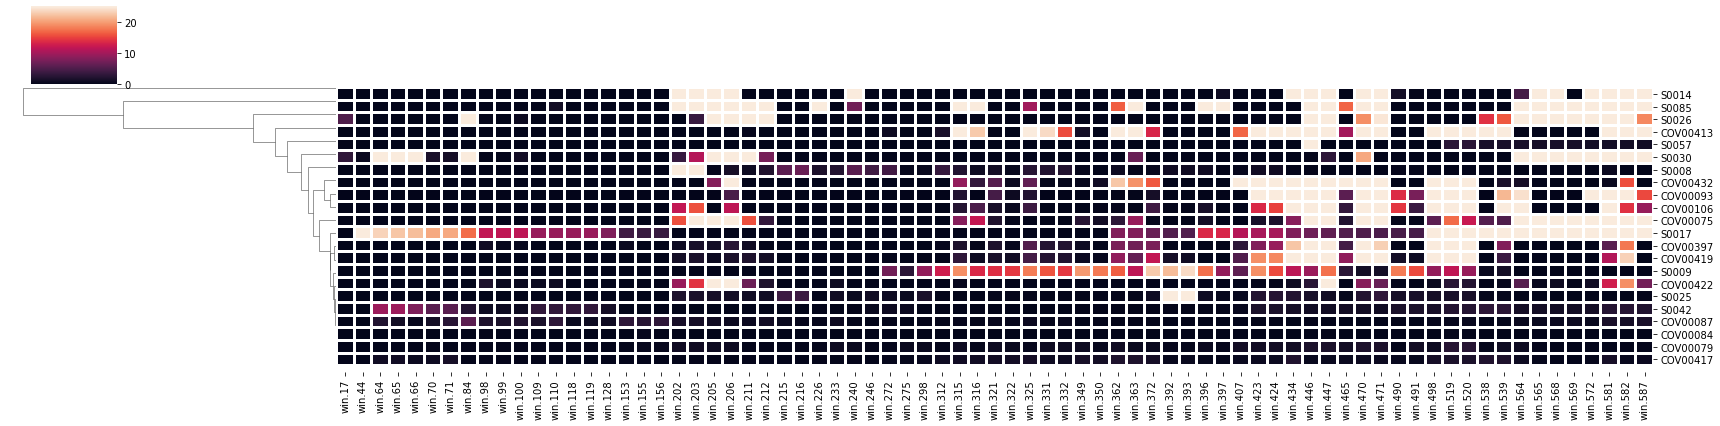

In [191]:
draw_heatmap(
    (-1)*log_p, vmax=25,
#     borders=make_significant_list(p_val_binary),
    cluster=True
)

In [192]:
# draw_heatmap(log_fdr.loc[:,peaks_with_motifs],borders=borders)

# Sanity check

In [193]:
P_VALUE = 5

cell_paper_log_p  = pd.read_csv('Results/ctest_Log_p_cell_paper.txt', sep='\t',index_col=0 )
cell_paper_log_fdr= pd.read_csv('Results/ctest_Log_fdr_cell_paper.txt', sep='\t',index_col=0)
cell_paper_log_fc = pd.read_csv('Results/ctest_Log_fc_cell_paper.txt', sep='\t',index_col=0)

cell_paper_p_val_binary = (-1)*cell_paper_log_p > P_VALUE

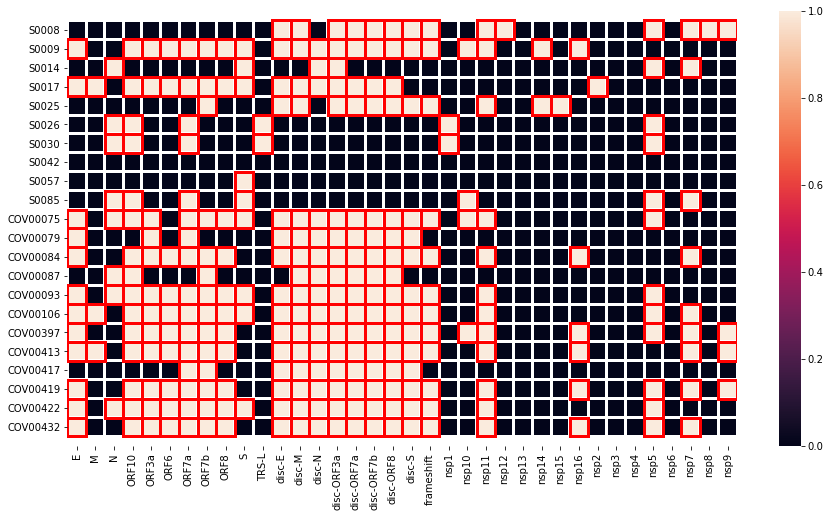

In [194]:
draw_heatmap(
    cell_paper_p_val_binary,
    borders=make_significant_list(cell_paper_p_val_binary), figsize=(15,8)
)

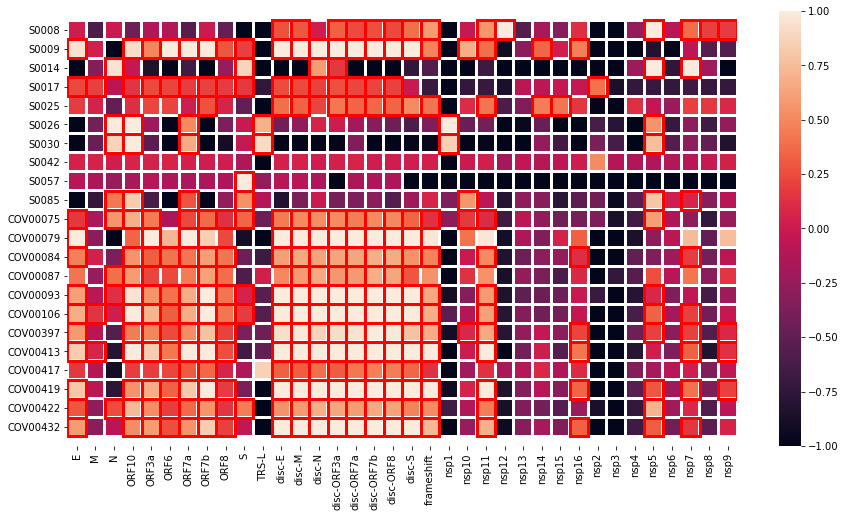

In [198]:
draw_heatmap(
    cell_paper_log_fc, vmin=-1,vmax=1,
    borders=make_significant_list(cell_paper_p_val_binary), figsize=(15,8)
)

In [200]:
# draw_heatmap(
#     cell_paper_log_fdr, vmin=-1,vmax=1,
#     borders=make_significant_list(cell_paper_p_val_binary), figsize=(15,8)
# )

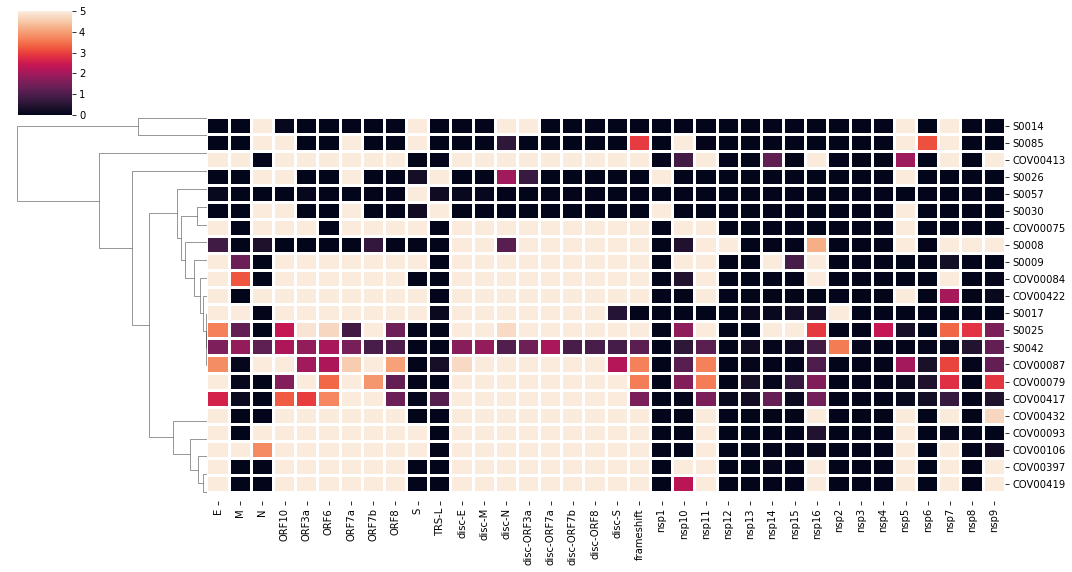

In [211]:
draw_heatmap(
    (-1)*cell_paper_log_p,vmax=P_VALUE, cluster = True,
#     borders=make_significant_list(cell_paper_p_val_binary), 
    figsize=(15,8)
)

### Total number of reads:


In [207]:
# pd.read_csv('total_reads.txt',  sep='\t',index_col=0 )

In [213]:
# data = dict(
#     type='sankey',
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(
#         color = "black",
#         width = 0.5
#       ),
#       label = ["Total", "Virus", "Host" ,"Control", "Unmapped", "+Leader", "-Leader", "N-Genomic", "Mito"],
#       color = ["yellow", "yellow", "yellow", "yellow", "yellow", "maroon", "maroon", "blue", "blue"],
#       #x = [0, .5, .5, .5, 1, 1, 1, 1, 1],
#       #y = [0, 0, .5, 1, 0, 0.2, 0.4, 0.6, 0.8, 1],
       
#     ),
#     link = dict(
#       source = [0, 0, 0, 0, 1, 1, 2, 2],
#       target = [1, 2, 3, 4, 5, 6, 7, 8],
#       value = [65.39, 22.9, 7.01, 4.71, 31.95, 33.45, 16.23, 6.66]
#   ))

# layout =  dict(
#     title = "Figure 2A",
#     font = dict(
#       size = 10
#     )
# )

# fig = dict(data=[data], layout=layout)
# ret = plot(fig, validate=False)
# print(ret)

# shutil.copy(ret, 'sankey-2A.html')
# IFrame(src='./temp-plot.html', width=700, height=600)